Based on:

https://www.dominodatalab.com/blog/named-entity-recognition-ner-challenges-and-model

# Install packages

In [1]:
!pip install plot_keras_history
!pip install keras==2.3.1
!pip install tensorflow==2.2.0
!pip install pyconll
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install conllu

You should consider upgrading via the '/home/digitalhub/.pyenv/versions/3.8.12/bin/python3.8 -m pip install --upgrade pip' command.
  Using cached Keras-2.3.1-py2.py3-none-any.whl (377 kB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 2.3.1 which is incompatible.
tensorflow-gpu 2.7.0 requires tensorboard~=2.6, but you have tensorboard 2.2.2 which is incompatible.
tensorflow-gpu 2.7.0 requires tensorflow-estimator<2.8,~=2.7.0rc0, but you have tensorflow-estimator 2.2.0 which is incompatible.
You should consider upgrading via the '/home/digitalhub/.pyenv/versions/3.8.12/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgr

# Import packages

In [2]:
import pickle
import operator
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyconll
import tensorflow as tf

from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from keras_contrib.utils import save_load_utils

from tensorflow.keras import layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input

from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics

2022-12-05 12:27:44.519497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-05 12:27:44.519513: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.


# Baseline model



## Import and preprocess general data

In [3]:
#Download Groningen Meaning Bank (GMB) data: https://gmb.let.rug.nl/about.php for baseline
train_path = 'ner_data/ner_dataset.csv'
bl_data = pd.read_csv(train_path, encoding="iso-8859-1", header=0)
bl_data.drop(columns=['POS'])

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O
...,...,...,...
1048570,NaN,they,O
1048571,NaN,responded,O
1048572,NaN,to,O
1048573,NaN,the,O


In [4]:
bl_data.ffill(inplace=True) #forward fill sentence column
bl_data['Sentence #'] = bl_data['Sentence #'].apply(lambda i: i[9:]) #reformat sentence column
bl_data["Sentence #"] = bl_data["Sentence #"].astype("int32") #change sentence column type
bl_data.rename(columns = {'Sentence #':'Sentence'}, inplace = True)

In [5]:
#Function to get dictionary of all unique items ('Word' and 'Tag')
#Returns 1 dictionary of index:item pairs and 1 dictionary of item:index pairs
def get_dict_map(data, column):
    item2idx = {}
    idx2item = {}
    
    corpus = list(set(data[column].to_list())) #get list of unique words/tags

    idx2item = {index:item for index, item in enumerate(corpus)}
    item2idx = {item:index for index, item in enumerate(corpus)}
    
    return idx2item, item2idx

In [6]:
def group_data(data, word2idx, tag2idx):

  #Create index columns for 'Word' and 'Tag'
  data['Word_index'] = data['Word'].map(word2idx)
  data['Tag_index'] = data['Tag'].map(tag2idx)

  #For each sentence, create a sequence of words, pos, tags, word indexes, tag indexes
  data_group = data.groupby(['Sentence'],as_index=False)['Word', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))
  return data_group

In [7]:
  #Get index to word, word to index, index to tag, tag to index mapping
  idx2word, word2idx = get_dict_map(bl_data, 'Word')
  idx2tag, tag2idx = get_dict_map(bl_data, 'Tag')

In [8]:
bl_data_group = group_data(bl_data, word2idx, tag2idx)

/tmp/ipykernel_22950/3682637150.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_group = data.groupby(['Sentence'],as_index=False)['Word', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))


## Prepare train and test data


In [9]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.utils import to_categorical

In [10]:
def get_pad_train_test_val(data_group, data):

    #total num of unique words and tags
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad Words (X var)    
    words = data_group['Word_index'].tolist()
    maxlen = max([len(word) for word in words])
    pad_tokens = pad_sequences(words, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_index'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags] #one hot encoding
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_words length:', len(train_tokens),
        '\ntrain_tags length:', len(train_tags),
        '\nval_words:', len(val_tokens),
        '\nval_tags:', len(val_tags),
        '\ntest_words length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),

    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

In [40]:
train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(bl_data_group, bl_data)

train_words length: 32372 
train_tags length: 32372 
val_words: 10791 
val_tags: 10791 
test_words length: 4796 
test_tags: 4796


## Model

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from keras_contrib.utils import save_load_utils

#from keras import layers
#from keras import optimizers

#from keras.models import Model
#from keras.models import Input

#from keras_contrib.layers import CRF
#from keras_contrib import losses
#from keras_contrib import metrics

In [13]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

In [14]:
input_dim = len(list(set(bl_data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in bl_data_group['Word_index'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  64 
input_length:  104 
n_tags:  17


In [15]:
#Function to initialise and structure NN architecture
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [16]:
#Function to train model, returns list of losses for each epoch
def train_model(X, y, model):
    loss = list()
    for i in range(25): #run 25 epochs in total
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

In [17]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

2022-12-05 12:27:48.405219: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-05 12:27:48.405251: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dh-minion2): /proc/driver/nvidia/version does not exist
2022-12-05 12:27:48.405952: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251456   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 64)           49408     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           1105      
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
26/26 [==============================] - 19s 743ms/step - loss: 0.1229 - a

In [18]:
#Visualise model architecture
plot_model(model_bilstm_lstm)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


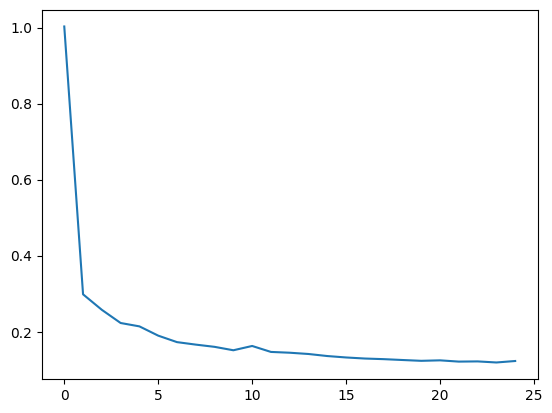

In [19]:
#Visualise loss curve of 25 epochs
plt.plot(results['with_add_lstm'])

In [41]:
y_pred = model_bilstm_lstm.predict(train_tokens)

y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(train_tags, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}".format(accuracy))


Accuracy: 0.1811


In [42]:
y_pred = model_bilstm_lstm.predict(test_tokens)

y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(test_tags, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.1817


In [36]:
def tag_conf_matrix(cm, tagid):
    tag_name = idx2tag[tagid]
    print("Tag name: {}".format(tag_name))
    print(cm[tagid])
    tn, fp, fn, tp = cm[tagid].ravel()
    tag_acc = (tp + tn) / (tn + fp + fn + tp)
    print("Tag accuracy: {:.3f} \n".format(tag_acc))

matrix = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())

tag_conf_matrix(matrix, 8)
tag_conf_matrix(matrix, 14)

Tag name: B-Organisation
[[11837     0]
 [   21     0]]
Tag accuracy: 0.998 

Tag name: B-DocumentReference
[[11855     0]
 [    3     0]]
Tag accuracy: 1.000 



In [43]:
idx2tag


{0: 'I-Location',
 1: 'I-Nationality',
 2: 'I-Organisation',
 3: 'I-DocumentReference',
 4: 'I-Temporal',
 5: 'B-Location',
 6: 'B-Temporal',
 7: 'I-Weapon',
 8: 'B-Organisation',
 9: 'B-Quantity',
 10: 'B-Person',
 11: 'I-Money',
 12: 'I-Person',
 13: 'B-MilitaryPlatform',
 14: 'B-DocumentReference',
 15: 'B-Money',
 16: 'B-Weapon',
 17: 'I-MilitaryPlatform',
 18: 'O',
 19: 'I-Quantity',
 20: 'B-Nationality'}

In [21]:
model_bilstm_lstm

# Domain-specific model

## Import and preprocess domain-specific model

In [22]:
#Prepare dataframe from text file
def prepare_data(path):
  data = pd.DataFrame(columns=['Sentence', 'Word', 'Tag'])
  with open(path) as f:
    sentence = 0
    for line in f:
      if line == '\n':
        sentence += 1
      else:
        split = line.split("\t")
        word = split[0]
        tag = split[1].strip()
        new_row = {'Sentence': sentence, 'Word': word, 'Tag': tag}
        data = data.append(new_row, ignore_index=True)
  return data

In [23]:
train_path = 'entity-recognition-datasets-master/data/re3d/CONLL-format/data/train/re3d-train.conll'
train_df = prepare_data(train_path)
test_path = 'entity-recognition-datasets-master/data/re3d/CONLL-format/data/test/re3d-test.conll'
test_df = prepare_data(test_path)

In [24]:
ds_data = pd.concat([train_df, test_df])

In [25]:
word_counts = ds_data.groupby("Sentence")["Word"].agg(["count"])
MAX_SENTENCE = word_counts.max()[0]

In [26]:
#Get index to word, word to index, index to tag, tag to index mapping
idx2word, word2idx = get_dict_map(ds_data, 'Word')
idx2tag, tag2idx = get_dict_map(ds_data, 'Tag')

In [27]:
ds_data_group = group_data(ds_data, word2idx, tag2idx)

/tmp/ipykernel_22950/3682637150.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_group = data.groupby(['Sentence'],as_index=False)['Word', 'Tag', 'Word_index', 'Tag_index'].agg(lambda x: list(x))


## Prepare data

In [28]:
#train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(ds_data_group, ds_data)

In [29]:
def get_pad_train_test(data_group, data):

    #total num of unique words and tags
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad Words (X var)    
    words = data_group['Word_index'].tolist()
    maxlen = max([len(word) for word in words])
    pad_tokens = pad_sequences(words, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_index'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags] #one hot encoding
    
    #Split train, test and validation set
    train_tokens, test_tokens, train_tags, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)

    print(
        'train_words length:', len(train_tokens),
        '\ntrain_tags length:', len(train_tags),
        '\ntest_words length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),

    )
    
    return train_tokens, test_tokens, train_tags, test_tags

In [30]:
train_tokens, test_tokens, train_tags, test_tags = get_pad_train_test(ds_data_group, ds_data)

train_words length: 688 
train_tags length: 688 
test_words length: 77 
test_tags: 77


In [31]:
train_tokens = np.array(train_tokens)
test_tokens = np.array(test_tokens)
train_tags = np.array(train_tags)
test_tags = np.array(test_tags)

## Model

In [32]:
seed(1)
tf.random.set_seed(2)

In [33]:
WORD_COUNT = len(idx2word)
TAG_COUNT = len(idx2tag)
DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 5

In [34]:
input_layer = Input(shape=(MAX_SENTENCE,))

model = Embedding(WORD_COUNT, DENSE_EMBEDDING, embeddings_initializer="uniform", input_length=MAX_SENTENCE)(input_layer)

model = Bidirectional(LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)

model = TimeDistributed(Dense(DENSE_UNITS, activation="relu"))(model)

crf_layer = CRF(units=TAG_COUNT)
output_layer = crf_layer(model)

ner_model = Model(input_layer, output_layer)

loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

ner_model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

ner_model.summary()

/home/digitalhub/.pyenv/versions/3.8.12/lib/python3.8/site-packages/keras/backend/tensorflow_backend.py:3201: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if training is 1 or training is True:
/home/digitalhub/.pyenv/versions/3.8.12/lib/python3.8/site-packages/keras/backend/tensorflow_backend.py:3207: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif training is 0 or training is False:
/home/digitalhub/.pyenv/versions/3.8.12/lib/python3.8/site-packages/keras/backend/tensorflow_backend.py:3201: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if training is 1 or training is True:
/home/digitalhub/.pyenv/versions/3.8.12/lib/python3.8/site-packages/keras/backend/tensorflow_backend.py:3207: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif training is 0 or training is False:
/home/digitalhub/.pyenv/versions/3.8.12/lib/python3.8/site-packages/keras/backend/tensorflow_backend.py:3201: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if trai

AttributeError: module 'tensorflow.python.framework.ops' has no attribute '_TensorLike'

In [ ]:
history = ner_model.fit(train_tokens, train_tags, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS)

Epoch 1/5


AttributeError: in user code:

    File "/home/digitalhub/.pyenv/versions/3.8.12/lib/python3.8/site-packages/keras_contrib/losses/crf_losses.py", line 54, in crf_loss  *
        crf, idx = y_pred._keras_history[:2]

    AttributeError: 'Tensor' object has no attribute '_keras_history'


: 

In [ ]:
train_tags

array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

: 

In [ ]:
train_tokens

array([[3182, 2885, 1140, ..., 4293, 4293, 4293],
       [ 536, 3389,  359, ..., 4293, 4293, 4293],
       [1436, 3246, 1773, ..., 4293, 4293, 4293],
       ...,
       [1436,  164,  274, ..., 4293, 4293, 4293],
       [1178, 4278, 2968, ..., 4293, 4293, 4293],
       [  26, 2974, 1140, ..., 4293, 4293, 4293]], dtype=int32)

: 

In [ ]:
train_tags

[array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],


: 

In [ ]:
input_dim = len(list(set(ds_data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in ds_data_group['Word_index'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  4295 
output_dim:  64 
input_length:  154 
n_tags:  21


: 

In [ ]:
#Function to initialise and structure NN architecture
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

: 

In [ ]:
#Function to train model, returns list of losses for each epoch
def train_model(X, y, model):
    loss = list()
    for i in range(25): #run 25 epochs in total
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.1)
        loss.append(hist.history['loss'][0])
    return loss

: 

In [ ]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 154, 64)           274880    
                                                                 
 bidirectional_5 (Bidirectio  (None, 154, 128)         66048     
 nal)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 154, 64)           49408     
                                                                 
 time_distributed_5 (TimeDis  (None, 154, 21)          1365      
 tributed)                                                       
                                                                 
Total params: 391,701
Trainable params: 391,701
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) a

: 

In [ ]:
y_pred = model_bilstm_lstm.predict(test_tokens)

y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(test_tags, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.9440


: 